### Objective: Calculate hydrophobicity on therapeutic antibodies

In this notebook, I am testing out some new code for calculating hydrophobicities on therapeutic antibodies. Hydrophobicities can be used to predict .. 


##### Import modules 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from developability.utils import ls, extract_sequence_from_pdb, plot_correlogram
from developability.hydrophobicity import HydrophobicSurface
from developability.descriptors import annotate_residues_with_fv_regions
from dask import delayed, compute
from tqdm.notebook import tqdm

%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)


In [18]:
base_path = Path("/Users/ChristopherRivera/Documents/DataResults")
data_path = base_path /"TherapeuticAntibodies"
[d for d in ls(data_path) if d.is_dir()]

[PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/Biophysical:Chemical data for abs'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/AbodyBuilder2_predicted_renumbered_stuctures'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/ABodyBuilder2_predicted_structures'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/solved_protein_electrostatics'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/HeavyLightChainAbPdbs'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/fv_only_pbds'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/aligned_antibodies'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/solved_therapeutic_abs')]

In [3]:
path = data_path / 'fv_only_pbds' 
paths = [p for p in ls(path) if p.is_dir() and 'output' in p.name]
paths


[PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/fv_only_pbds/necitumumab_3b2u_outputs'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/fv_only_pbds/fulranumab_4m6o_outputs'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/fv_only_pbds/epratuzumab_5vkk_outputs'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/fv_only_pbds/basiliximab_1mim_outputs'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/fv_only_pbds/crenezumab_5vzy_outputs'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/fv_only_pbds/nimotuzumab_3gkw_outputs'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/fv_only_pbds/bapineuzumab_4ojf_outputs'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/fv_only_pbds/lumiliximab_3fzu_outputs'),
 PosixPath('/Users/Christ

In [4]:
def region_hydrophobicities(residue_hydrophobicity_df):
    """ Calculates the potentials for regions
    TODO: refactor this function to make cleaner. 
    Args: 
        residue_hydrophobicity_df(pd.DataFrame): annotated DataFrame with the residue hydrophobicities 
    Returns: 
        vals(dict): dict with values

    """
    
    def calculate_hydrophobicity(region, chain, hydrophobicity='pos'): 
        """ Calculates the hydrophobicity
        Args: 
            region(str|list[str]): the region to calculate
            chain(str|list[str]): the chain to calculate
            hydrophobicity(str): the hydrophobicity to calculate (positive, negative, net)
        Returns: 
            float: the potential for the region
        """

        if isinstance(region, str):
            region = [region]   

        if isinstance(chain, str):  
            chain = [chain]

        if hydrophobicity=='pos':
            df = residue_hydrophobicity_df.query('Hydrophobicity > 0')
        elif hydrophobicity=='neg':
            df = residue_hydrophobicity_df.query('Hydrophobicity < 0')
        elif hydrophobicity=='net':
            df = residue_hydrophobicity_df
        else:
            raise ValueError('hydrophobicity must be pos, neg or net')    
        return df.loc[df.FV_region.isin(region) & df.FV_chain.isin(chain)]['Hydrophobicity'].sum()
            
    cdrs = ['CDR1','CDR2', 'CDR3']
    frameworks = ['FR1','FR2', 'FR3', 'FR4']
    all_regions = cdrs + frameworks
    chains = ['H', 'L']
    
    hydrophobicities = ['pos', 'neg', 'net']

    vals = {f'{chain}{region}_HYDRO_{hydrophobicity}': calculate_hydrophobicity(region, chain, hydrophobicity) for 
            chain in chains for region in all_regions for hydrophobicity in hydrophobicities}
    
    vals.update( {f'{chain}CDR_HYDRO_{hydrophobicity}': calculate_hydrophobicity(cdrs, chain, hydrophobicity) for
                  chain in chains for hydrophobicity in hydrophobicities})
    
    vals.update( {f'{chain}FR_HYDRO_{hydrophobicity}': calculate_hydrophobicity(frameworks, chain, hydrophobicity) for
                  chain in chains for hydrophobicity in hydrophobicities})

    vals.update( {f'{chain}C_HYDRO_{hydrophobicity}': calculate_hydrophobicity(all_regions, chain, hydrophobicity) for
                  chain in chains for hydrophobicity in hydrophobicities})
    
    vals.update({f'TOTAL_CDR_HYDRO_{hydrophobicity}': calculate_hydrophobicity(cdrs, chains, hydrophobicity) 
                  for hydrophobicity in hydrophobicities})   
    
    vals.update({f'TOTAL_FR_HYDRO_{hydrophobicity}': calculate_hydrophobicity(frameworks, chains, hydrophobicity) 
                  for hydrophobicity in hydrophobicities})
    
    vals.update({f'TOTAL_HYDRO_{hydrophobicity}': calculate_hydrophobicity(all_regions, chains, hydrophobicity) 
                  for hydrophobicity in hydrophobicities})
    
    return vals

def compute_hydrophobicity(path):
    name = path.name.split('_')[0]
    name = path.name.split('_')[0]
    pdb = path/'pdb4amber.pdb'
    sequences = extract_sequence_from_pdb(pdb)
    pqr = [f for f in ls(path) if f.name.endswith('.pqr')][0]
    atom_surface = path/'triangulatedSurf.atom.csv'
    hydro = HydrophobicSurface(pqr, atom_surface)

    residue_hydrophobicity = hydro.residue_hydrophobicities
    residue_hydrophobicity = annotate_residues_with_fv_regions(sequences, residue_hydrophobicity, scheme = 'kabat')
    residue_hydrophobicity.to_csv(path/'residue_hydrophobicity.csv')
    
    df = pd.DataFrame(region_hydrophobicities(residue_hydrophobicity), index=[name])

    return df, residue_hydrophobicity

In [5]:
test = paths[0]
hydros, res =  compute_hydrophobicity(test)

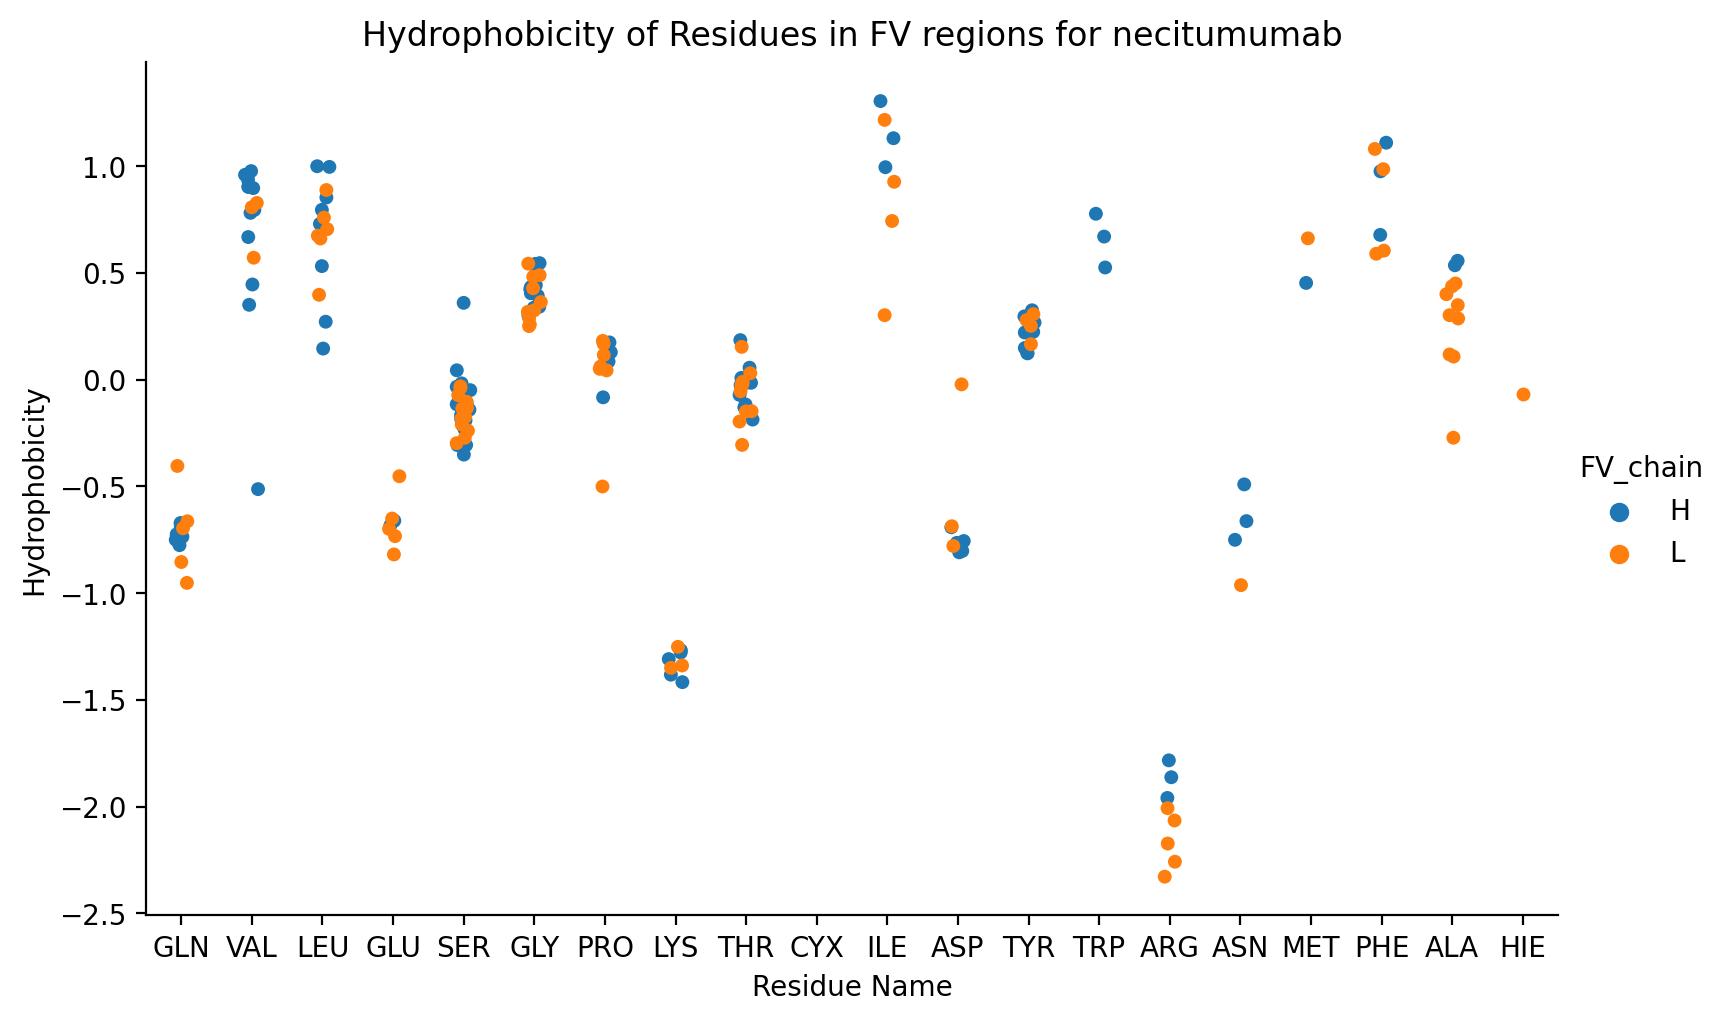

In [6]:
ax = sns.catplot(data=res, x='Residue_name', y= 'Hydrophobicity', hue='FV_chain', aspect = 1.6)
ax.set(title = f'Hydrophobicity of Residues in FV regions for {test.name.split("_")[0]}', xlabel = 'Residue Name', ylabel = 'Hydrophobicity')

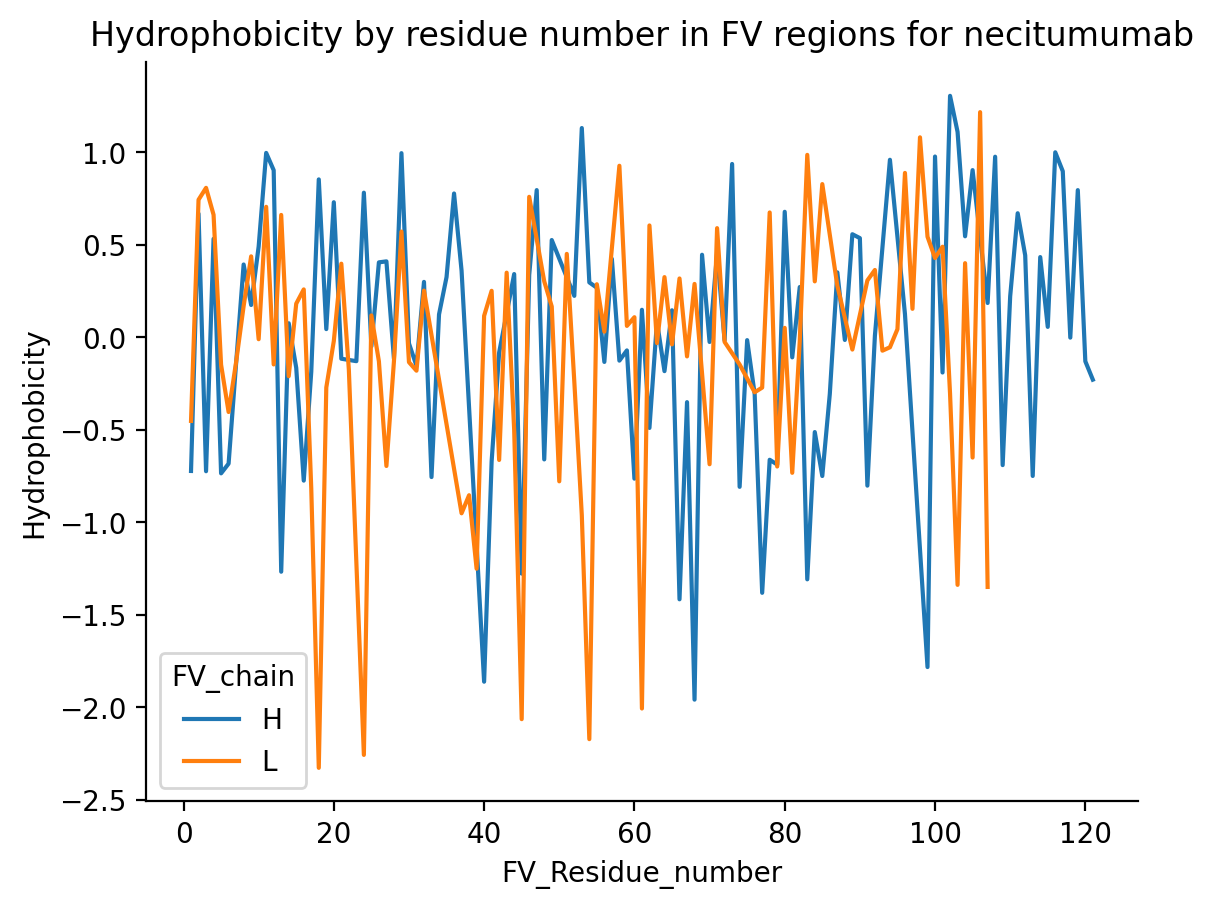

In [7]:
ax = sns.lineplot(data = res, x = 'FV_Residue_number', y='Hydrophobicity', hue='FV_chain')
ax.set(title = f'Hydrophobicity by residue number in FV regions for {test.name.split("_")[0]}')
sns.despine()

#### Compute for all 

In [8]:
hydros =[]
hydro_descriptors = []
names = []
for p in tqdm(paths): 
    try:
        descriptors, residue_hydrophobicity = compute_hydrophobicity(p)
        hydros.append(residue_hydrophobicity)
        hydro_descriptors.append(descriptors)
        names.append(p.name.split('_')[0])
    except:
        print(f'Error with {p.name}')
        continue
    

  0%|          | 0/51 [00:00<?, ?it/s]

In [9]:
hydro_descriptors_df = pd.concat(hydro_descriptors)

<Axes: title={'center': 'Correlation of positive hydrophobicity by region'}>

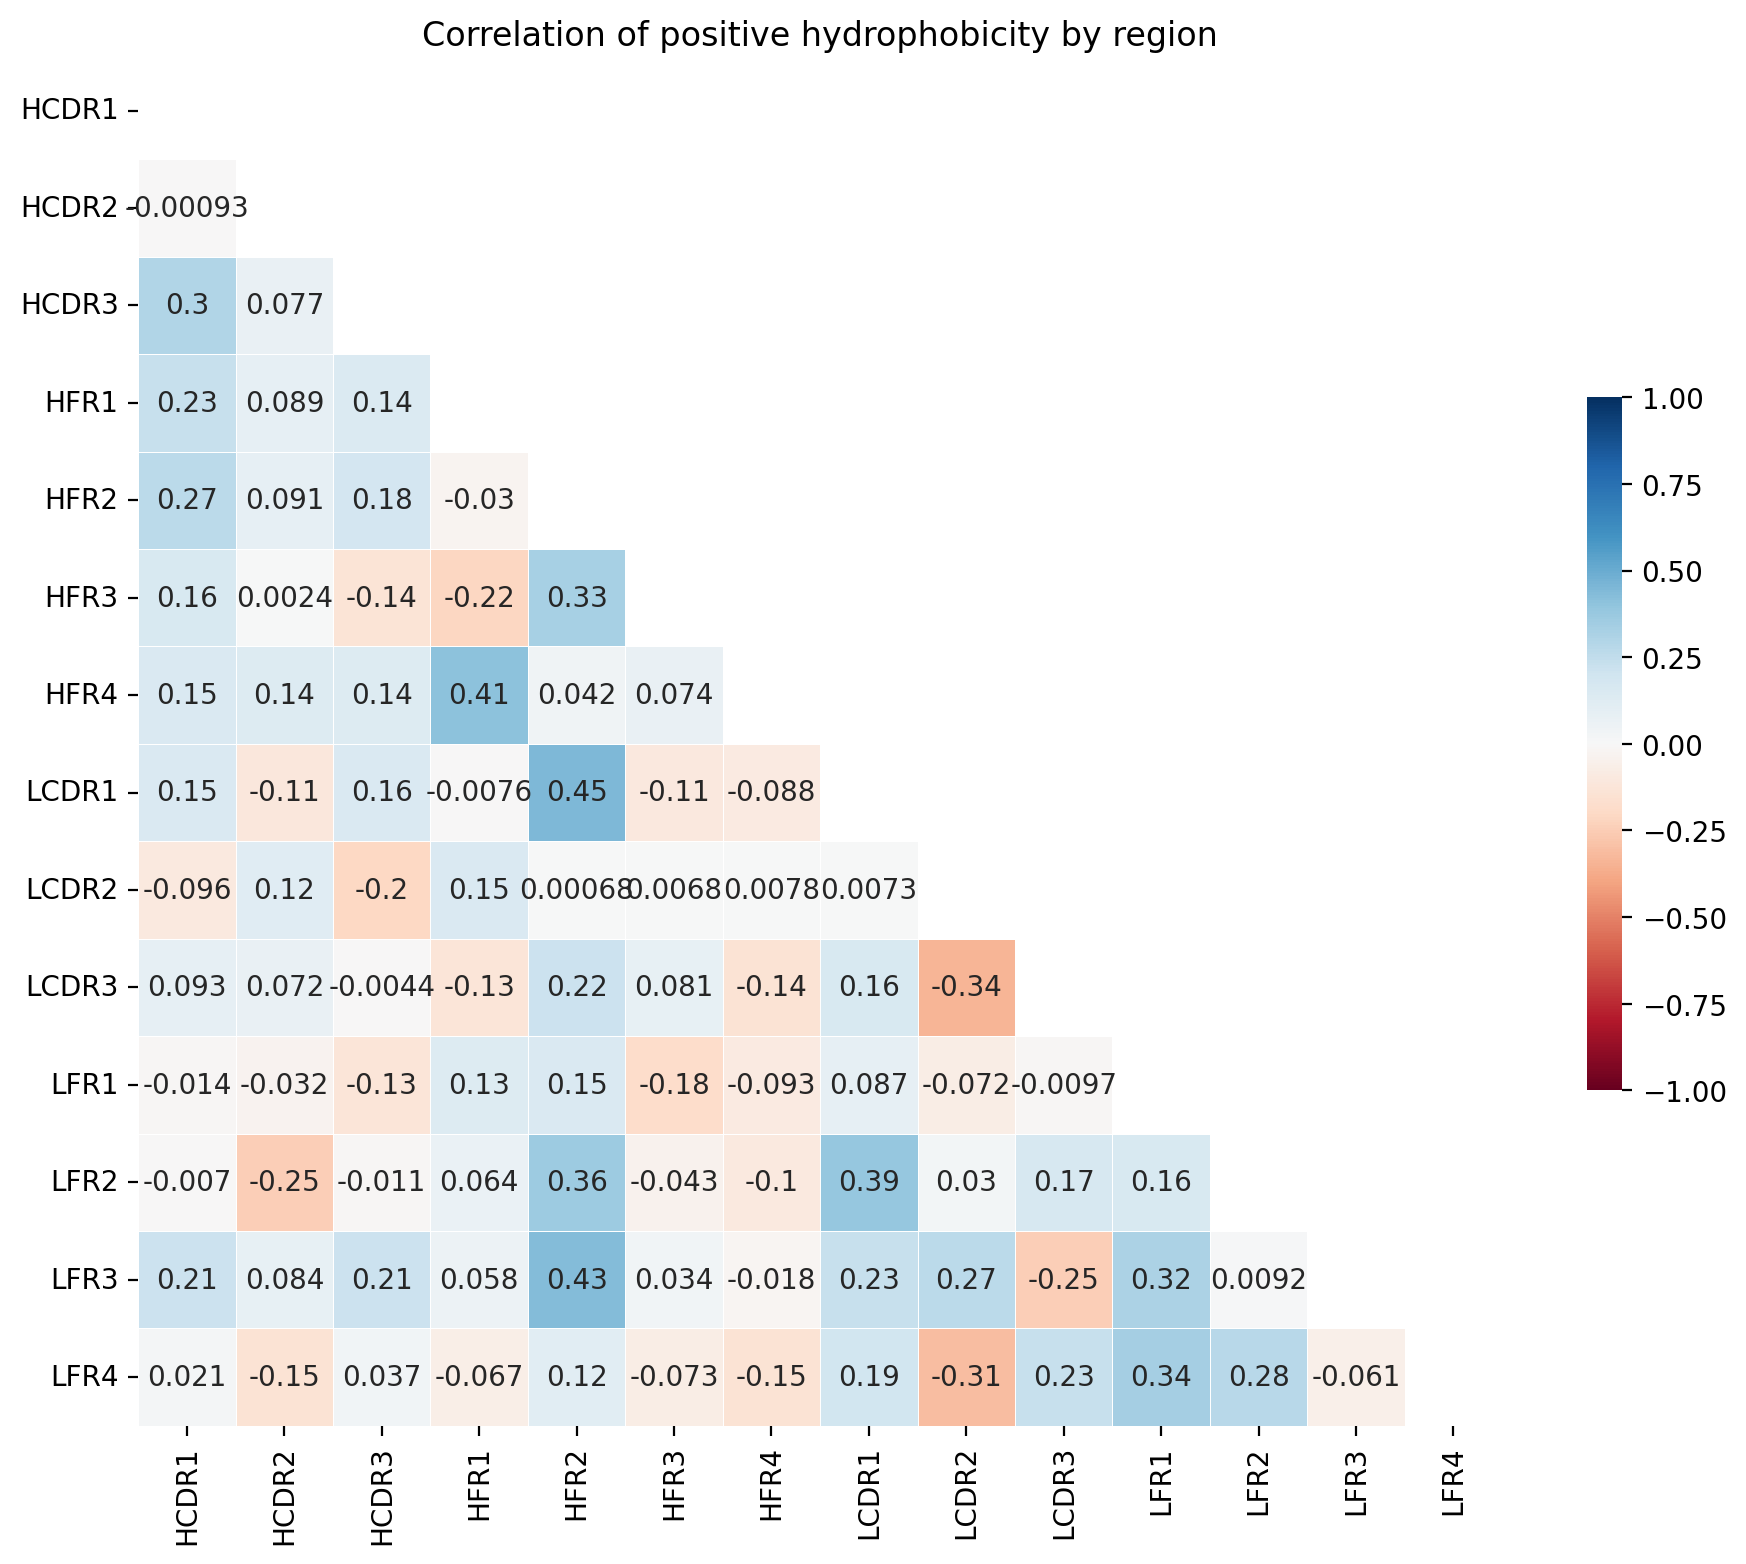

In [10]:
pos_cols = [col for col in hydro_descriptors_df.columns if 'pos' in col and ('1' in col or '2' in col or '3' in col or '4' in col)]
pos_descriptors = hydro_descriptors_df[pos_cols].rename({col: col.split('_')[0] for col in pos_cols}, axis=1).copy()
plot_correlogram(pos_descriptors, title = 'Correlation of positive hydrophobicity by region', annot=True, vmin = -1, vmax = 1)

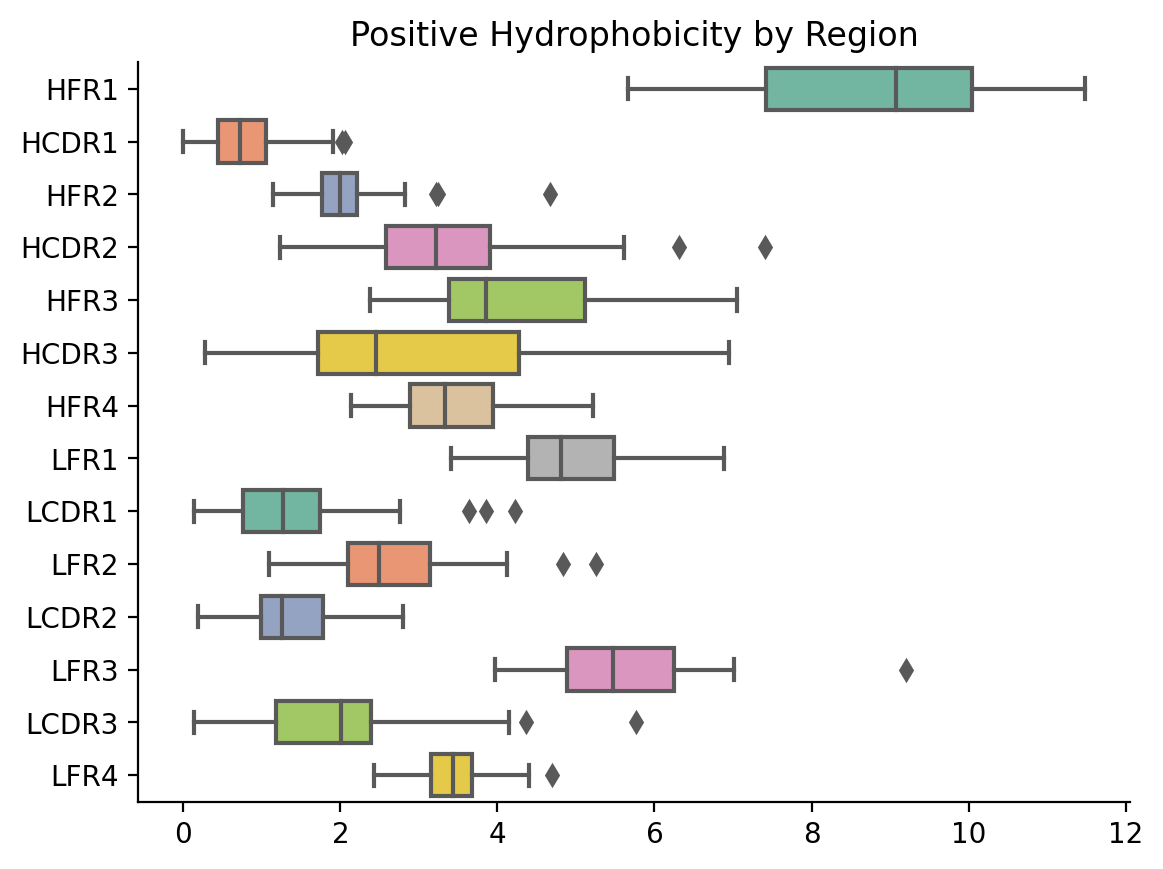

In [11]:
ax = sns.boxplot(data=pos_descriptors, orient='h', palette='Set2', order = ['HFR1', 'HCDR1', 'HFR2', 'HCDR2', 'HFR3', 'HCDR3', 'HFR4','LFR1', 'LCDR1', 'LFR2', 'LCDR2', 'LFR3', 'LCDR3', 'LFR4'])
ax.set(title = 'Positive Hydrophobicity by Region')
sns.despine()

In [12]:
invitro_df = pd.read_csv(data_path/'invitro_measurments_from_tushar_2023.csv')
cols = [col for col in invitro_df.columns if 'Unnamed' not in col]
invitro_df = invitro_df[cols].copy()
invitro_df.to_csv(data_path/'invitro_measurments_from_tushar_2023.csv', index=False)

In [13]:
index = [ab for ab in hydro_descriptors_df.index if ab in invitro_df.Name.values]
invitro_df = invitro_df.set_index('Name')
invitro_subset_df = invitro_df.loc[index].copy()
hydro_descriptors_invitro_df = hydro_descriptors_df.loc[index]



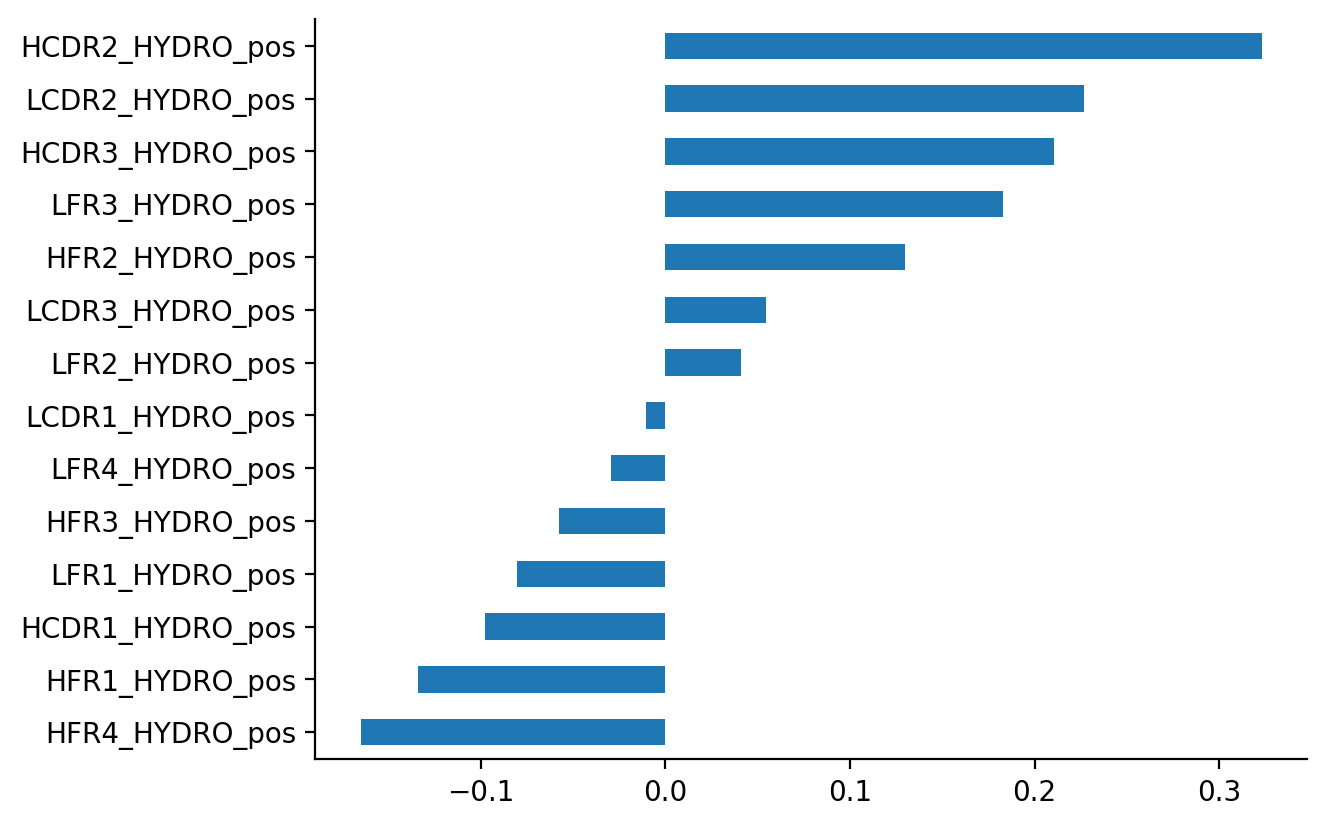

In [14]:
ax =hydro_descriptors_invitro_df[pos_cols].corrwith(invitro_subset_df['HIC']).sort_values(ascending=True).plot(kind = 'barh')
sns.despine()

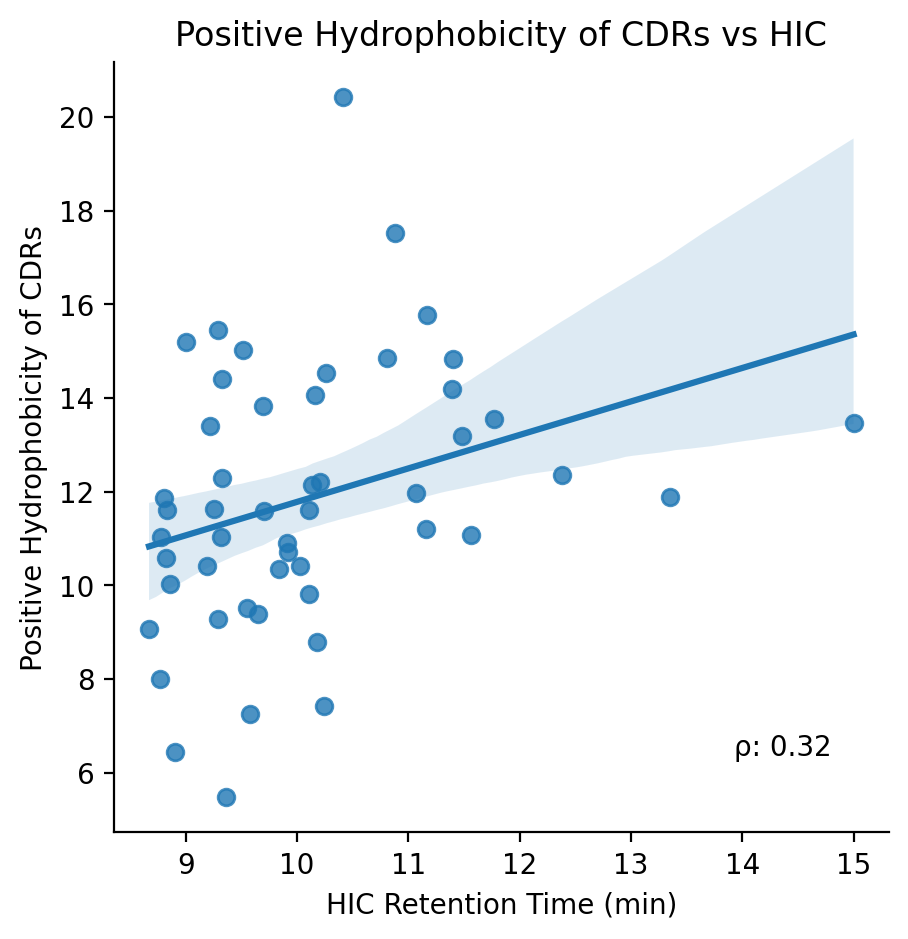

In [16]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.regplot(y=hydro_descriptors_invitro_df['TOTAL_CDR_HYDRO_pos'], x = invitro_subset_df['HIC'], ax = ax)
ax.set(title = 'Positive Hydrophobicity of CDRs vs HIC', xlabel = 'HIC Retention Time (min)', ylabel = 'Positive Hydrophobicity of CDRs')
correlation_coefficient = hydro_descriptors_invitro_df['TOTAL_CDR_HYDRO_pos'].corr(invitro_df['HIC'])

# Annotate the correlation coefficient on the plot
ax.annotate(f"\u03C1: {correlation_coefficient:.2f}", xy=(0.80, 0.1), xycoords='axes fraction')
sns.despine()

### Plot with smoothing. 

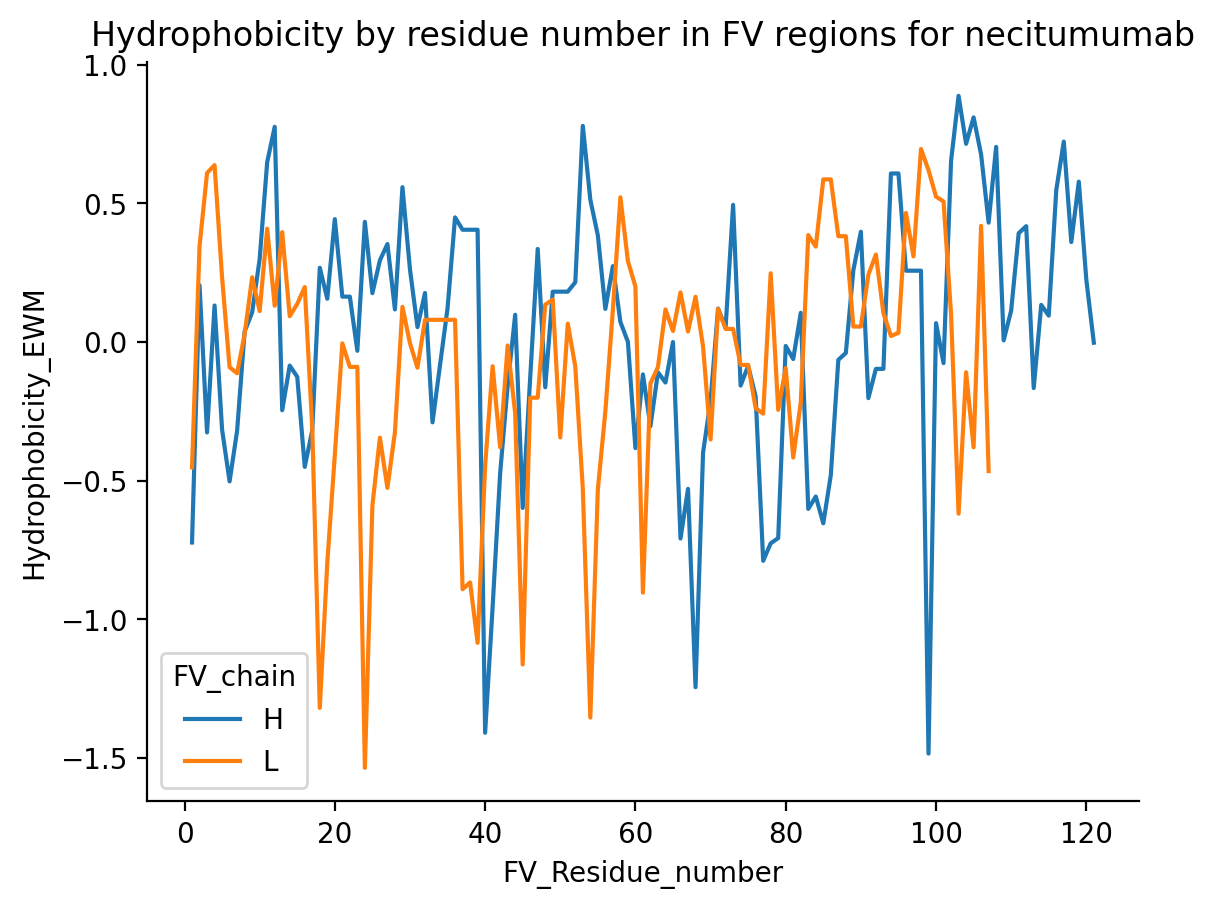

In [17]:
res['Hydrophobicity_EWM']= res.groupby('FV_chain')['Hydrophobicity'].transform(lambda x: x.ewm(span=3).mean())


ax = sns.lineplot(data = res, x = 'FV_Residue_number', y='Hydrophobicity_EWM', hue='FV_chain')
ax.set(title = f'Hydrophobicity by residue number in FV regions for {test.name.split("_")[0]}')
sns.despine()

### Redo with the computationally predicted data. 

Above, I am only using a subset of the therapeutic proteins with solved data. Here I am going to look 

In [24]:
predicted_path = data_path/'AbodyBuilder2_predicted_renumbered_stuctures'
predicted_paths = [p for p in ls(predicted_path) if p.is_dir() and 'outputs' in p.name]
predicted_paths[:5]

[PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/AbodyBuilder2_predicted_renumbered_stuctures/clazakizumab_outputs'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/AbodyBuilder2_predicted_renumbered_stuctures/seribantumab_outputs'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/AbodyBuilder2_predicted_renumbered_stuctures/ocrelizumab_outputs'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/AbodyBuilder2_predicted_renumbered_stuctures/fletikumab_outputs'),
 PosixPath('/Users/ChristopherRivera/Documents/DataResults/TherapeuticAntibodies/AbodyBuilder2_predicted_renumbered_stuctures/patritumab_outputs')]

In [32]:
descriptor_dfs = []

batches = np.array_split(predicted_paths,10)
for batch in tqdm(batches, total=len(batches)): 
    tasks  = [delayed(compute_hydrophobicity)(path) for path in batch]
    descriptor_dfs.extend([task[0] for task in compute(*tasks, scheduler='processes')])


  0%|          | 0/10 [00:00<?, ?it/s]

/Users/ChristopherRivera/Projects/developability/developability/hydrophobicity.py:115: FutureWarning: The provided callable <function mean at 0x104284cc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  .agg({'Hydrophobicity_avg': agg_func})
/Users/ChristopherRivera/Projects/developability/developability/hydrophobicity.py:123: FutureWarning: The provided callable <function mean at 0x104284cc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  .agg({'Hydrophobicity_avg': agg_func})
/Users/ChristopherRivera/Projects/developability/developability/hydrophobicity.py:115: FutureWarning: The provided callable <function mean at 0x103300cc0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current 

In [36]:
predicted_descriptors = pd.concat(descriptor_dfs).sort_index()
predicted_descriptors.head()

,HCDR1_HYDRO_pos,HCDR1_HYDRO_neg,HCDR1_HYDRO_net,HCDR2_HYDRO_pos,HCDR2_HYDRO_neg,HCDR2_HYDRO_net,HCDR3_HYDRO_pos,HCDR3_HYDRO_neg,HCDR3_HYDRO_net,HFR1_HYDRO_pos,HFR1_HYDRO_neg,HFR1_HYDRO_net,HFR2_HYDRO_pos,HFR2_HYDRO_neg,HFR2_HYDRO_net,HFR3_HYDRO_pos,HFR3_HYDRO_neg,HFR3_HYDRO_net,HFR4_HYDRO_pos,HFR4_HYDRO_neg,HFR4_HYDRO_net,LCDR1_HYDRO_pos,LCDR1_HYDRO_neg,LCDR1_HYDRO_net,LCDR2_HYDRO_pos,LCDR2_HYDRO_neg,LCDR2_HYDRO_net,LCDR3_HYDRO_pos,LCDR3_HYDRO_neg,LCDR3_HYDRO_net,LFR1_HYDRO_pos,LFR1_HYDRO_neg,LFR1_HYDRO_net,LFR2_HYDRO_pos,LFR2_HYDRO_neg,LFR2_HYDRO_net,LFR3_HYDRO_pos,LFR3_HYDRO_neg,LFR3_HYDRO_net,LFR4_HYDRO_pos,LFR4_HYDRO_neg,LFR4_HYDRO_net,HCDR_HYDRO_pos,HCDR_HYDRO_neg,HCDR_HYDRO_net,LCDR_HYDRO_pos,LCDR_HYDRO_neg,LCDR_HYDRO_net,HFR_HYDRO_pos,HFR_HYDRO_neg,HFR_HYDRO_net,LFR_HYDRO_pos,LFR_HYDRO_neg,LFR_HYDRO_net,HC_HYDRO_pos,HC_HYDRO_neg,HC_HYDRO_net,LC_HYDRO_pos,LC_HYDRO_neg,LC_HYDRO_net,TOTAL_CDR_HYDRO_pos,TOTAL_CDR_HYDRO_neg,TOTAL_CDR_HYDRO_net,TOTAL_FR_HYDRO_pos,TOTAL_FR_HYDRO_neg,TOTAL_FR_HYDRO_net,TOTAL_HYDRO_pos,TOTAL_HYDRO_neg,TOTAL_HYDRO_net
abituzumab,1.703596,-0.206814,1.496782,3.515217,-8.364895,-4.849678,2.682691,-2.604862,0.077829,6.489849,-8.660946,-2.171097,1.855732,-3.996593,-2.140861,2.672882,-8.406654,-5.733772,2.652051,-1.017564,1.634487,1.535285,-5.055202,-3.519917,1.332349,-1.717908,-0.385559,2.264640,-0.942270,1.322369,4.456436,-6.325539,-1.869103,1.329507,-5.737725,-4.408218,4.435118,-6.979462,-2.544344,3.349477,-4.635293,-1.285816,7.901504,-11.176570,-3.275067,5.132274,-7.715380,-2.583106,13.670514,-22.081757,-8.411243,13.570538,-23.678019,-10.107482,21.572018,-33.258328,-11.686310,18.702811,-31.393399,-12.690588,13.033778,-18.891951,-5.858173,27.241052,-45.759776,-18.518725,40.274829,-64.651727,-24.376898
abrilumab,2.355389,-0.740081,1.615308,4.089873,-5.829310,-1.739436,1.085278,-1.093099,-0.007821,7.814340,-8.342042,-0.527702,1.693976,-4.570120,-2.876144,2.400455,-9.087152,-6.686696,3.154227,-1.079824,2.074403,2.875598,-3.413274,-0.537676,1.884437,-1.150664,0.733773,2.694744,-0.520474,2.174271,4.683060,-7.789035,-3.105975,2.156997,-5.929548,-3.772552,4.841348,-6.895441,-2.054092,3.312068,-4.746865,-1.434798,7.530541,-7.662490,-0.131949,7.454779,-5.084411,2.370367,15.062999,-23.079137,-8.016139,14.993473,-25.360889,-10.367417,22.593539,-30.741627,-8.148088,22.448251,-30.445301,-7.997050,14.985319,-12.746901,2.238418,30.056471,-48.440027,-18.383556,45.041791,-61.186928,-16.145137
adalimumab,0.746769,-0.681008,0.065762,4.768466,-3.679253,1.089214,3.464921,-1.102423,2.362498,9.066062,-8.579745,0.486317,1.541322,-4.543584,-3.002262,3.979324,-15.439429,-11.460104,2.433261,-0.990175,1.443086,0.669480,-6.103339,-5.433860,1.718362,-0.879970,0.838392,0.954750,-5.069186,-4.114435,4.402514,-7.307796,-2.905282,2.279678,-5.820931,-3.541253,4.739313,-7.179747,-2.440434,3.265033,-4.484309,-1.219276,8.980156,-5.462683,3.517473,3.342592,-12.052495,-8.709903,17.019969,-29.552933,-12.532963,14.686538,-24.792783,-10.106245,26.000126,-35.015616,-9.015490,18.029130,-36.845278,-18.816148,12.322748,-17.515178,-5.192430,31.706508,-54.345716,-22.639209,44.029256,-71.860894,-27.831638
alemtuzumab,1.690958,-0.877822,0.813136,2.887102,-8.337364,-5.450262,1.192590,-2.039081,-0.846491,8.616307,-7.134420,1.481887,1.131472,-6.032344,-4.900872,6.250759,-11.391642,-5.140883,3.641352,-1.202076,2.439276,0.321863,-5.171212,-4.849350,0.957977,-2.712145,-1.754169,1.292366,-5.212585,-3.920219,4.417692,-6.148378,-1.730686,1.676561,-6.049845,-4.373284,5.142825,-6.951344,-1.808519,3.310537,-4.772316,-1.461779,5.770650,-11.254267,-5.483617,2.572205,-13.095942,-10.523737,19.639889,-25.760481,-6.120591,14.547615,-23.921882,-9.374267,25.410540,-37.014748,-11.604209,17.119820,-37.017824,-19.898004,8.342855,-24.350210,-16.007354,34.187505,-49.682363,-15.494858,42.530360,-74.032572,-31.502212
alirocumab,0.577937,-0.680346,-0.102409,2.880237,-3.639904,-0.759667,1.528688,-2.415604,-0.886915,9.761921,-6.620344,3.141577,1.934216,-4.836775,-2.902559,5.2015

In [51]:
invitro_df = invitro_df.sort_index()
invtro_subset2_df = invitro_df.loc[invitro_df.index.isin(predicted_descriptors.index)].copy()
predicted_descriptors2 = predicted_descriptors.loc[predicted_descriptors.index.isin(invtro_subset2_df.index)].copy()

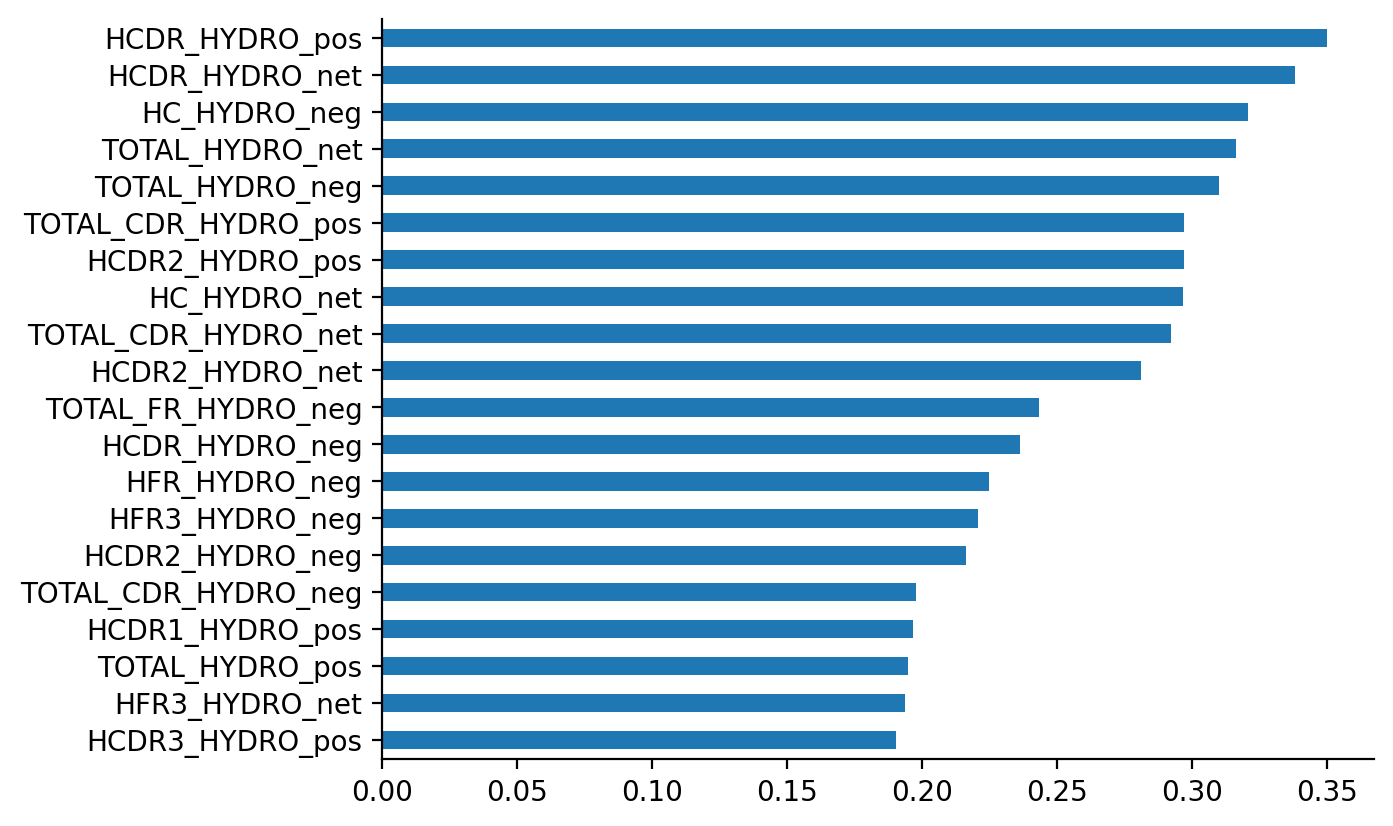

In [54]:
hic_corr = predicted_descriptors2.corrwith(invtro_subset2_df['HIC']).sort_values()
hic_corr.tail(20).plot(kind='barh')
sns.despine()

<Axes: title={'center': 'Correlation of positive hydrophobicity by region'}>

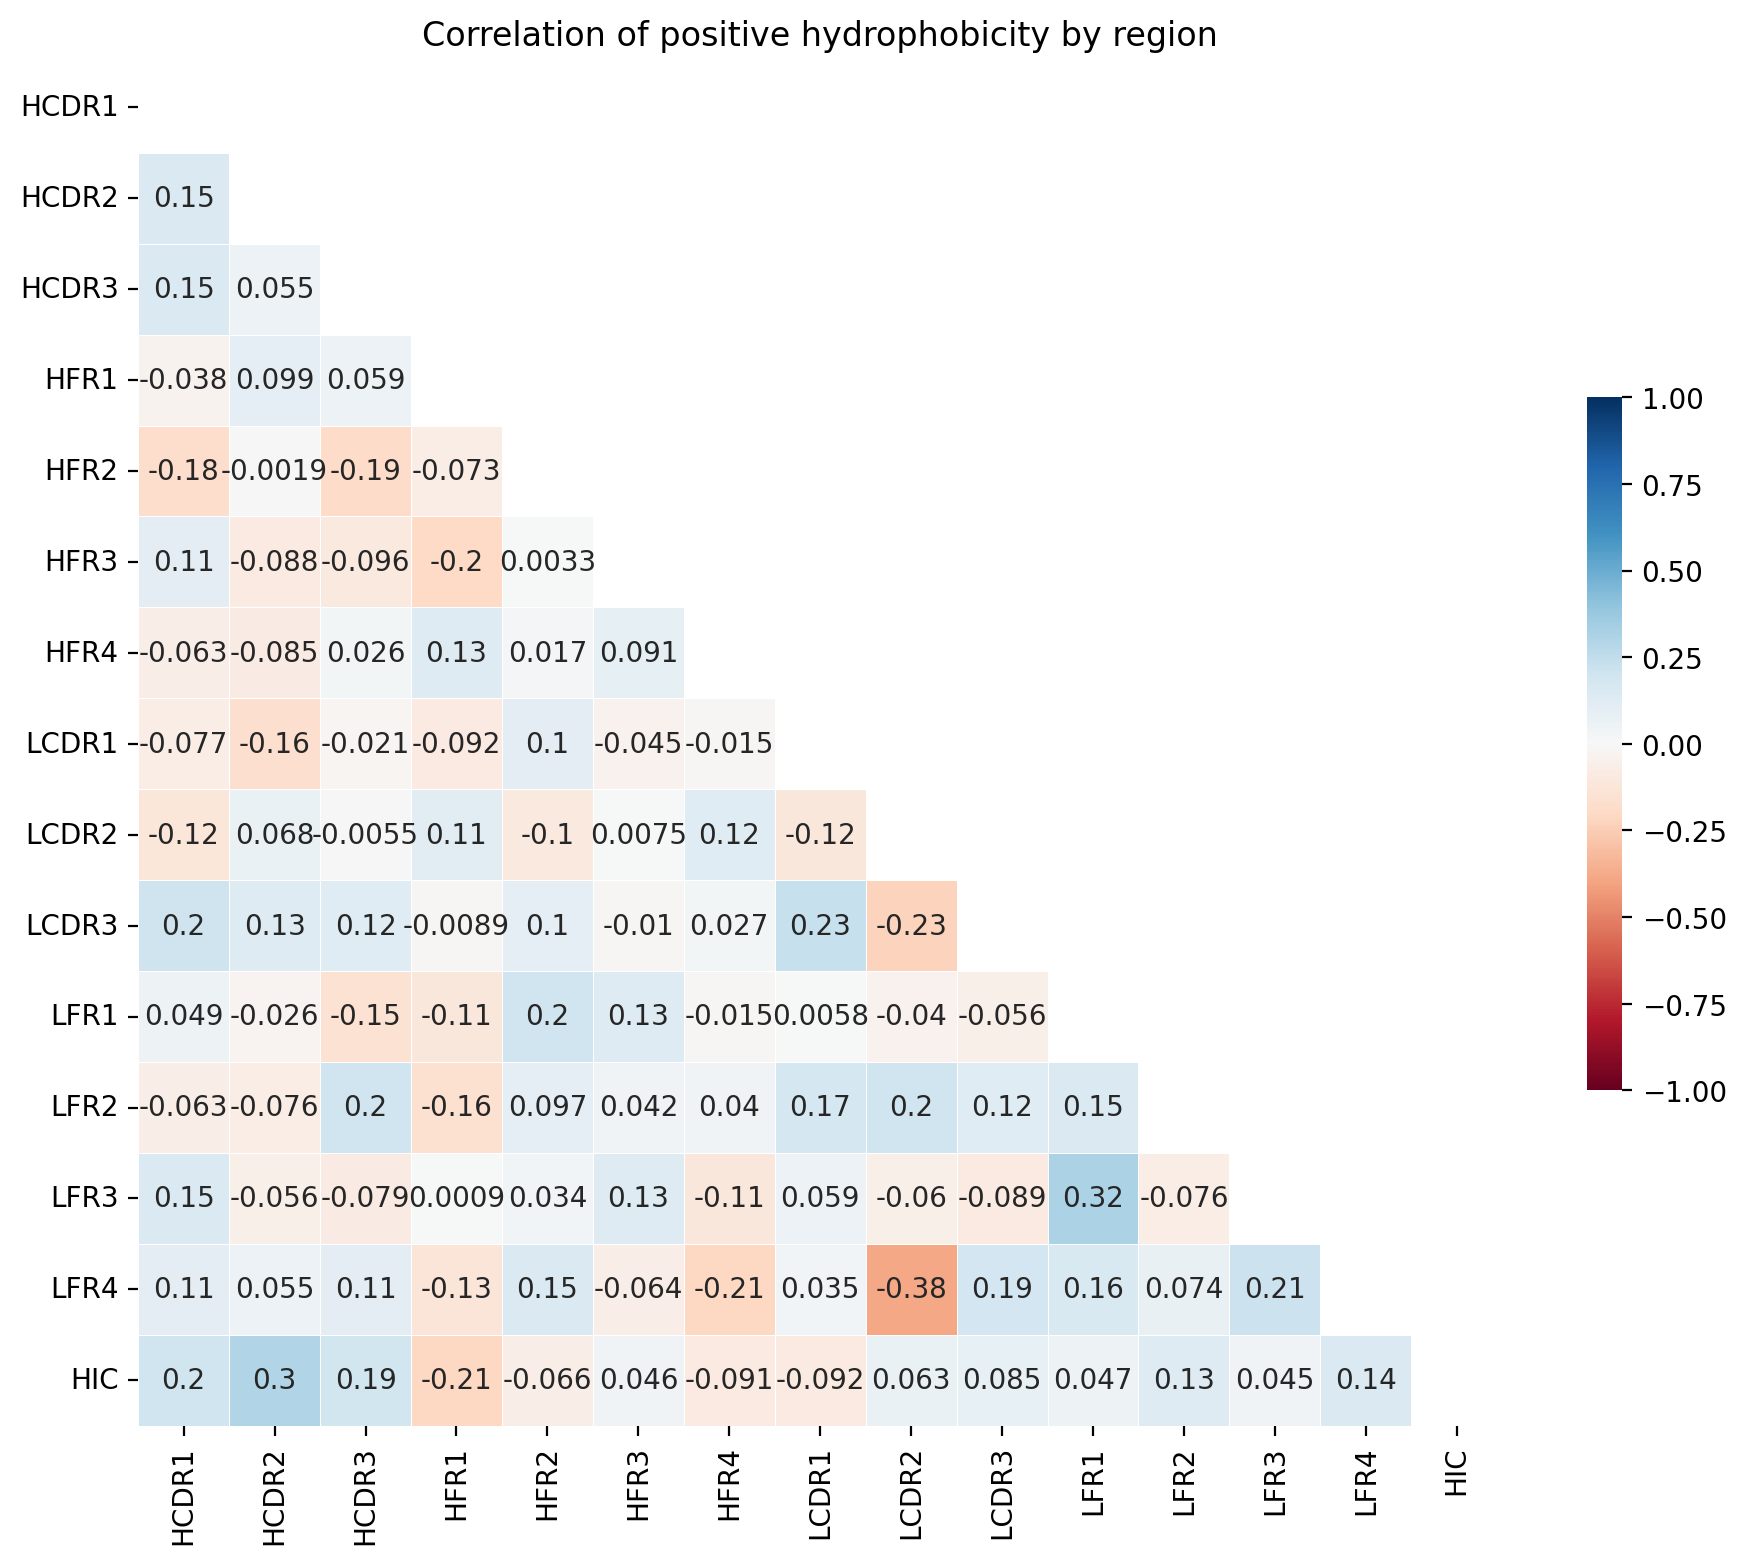

In [56]:
predicted_pos_descriptors = predicted_descriptors2[pos_cols].rename({col: col.split('_')[0] for col in pos_cols}, axis=1).copy()
predicted_pos_descriptors['HIC'] = invtro_subset2_df['HIC']
plot_correlogram(predicted_pos_descriptors, title = 'Correlation of positive hydrophobicity by region', annot=True, vmin = -1, vmax = 1)

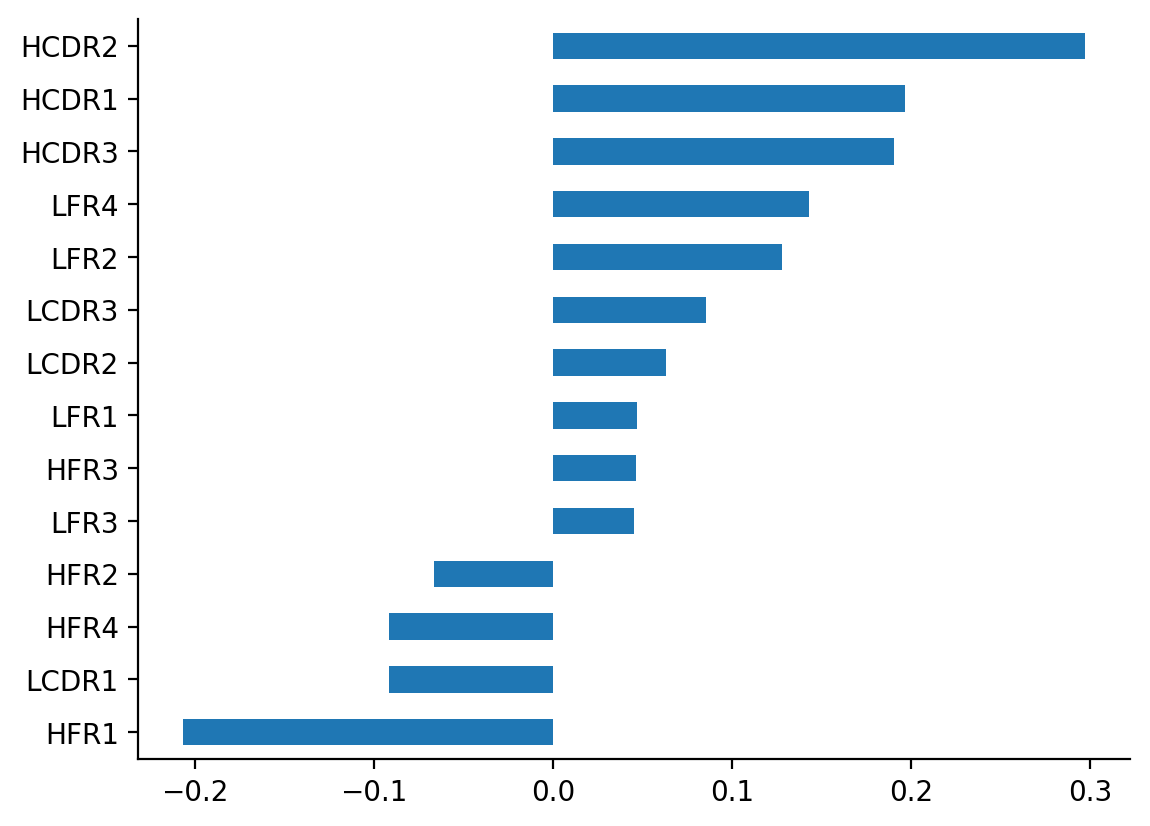

In [60]:
predicted_pos_descriptors.drop('HIC',axis=1).corrwith(predicted_pos_descriptors['HIC']).sort_values(ascending=True).plot(kind='barh')
sns.despine()

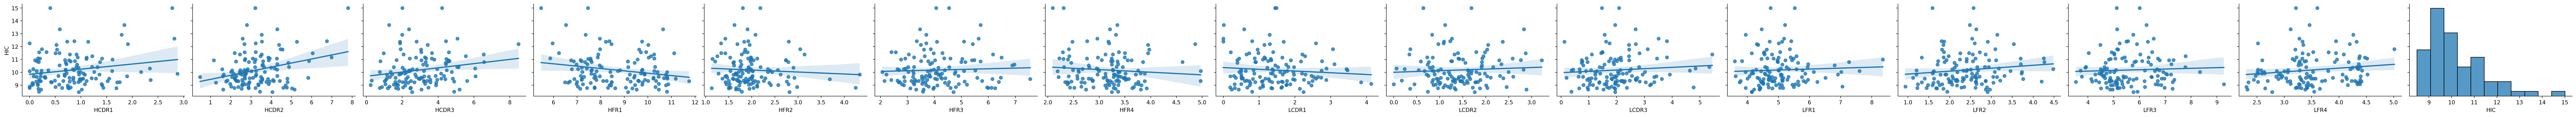

In [ ]:
sns.pairplot(data = predicted_pos_descriptors, y_vars = 'HIC', kind = 'reg', height = 3, aspect = 1.5)